In [2]:
import graphviz
import numpy as np
import scipy
import sklearn
import shap

In [3]:
X, y = shap.datasets.adult()

orig_model = sklearn.tree.DecisionTreeRegressor(max_depth=2)
orig_model.fit(X, y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


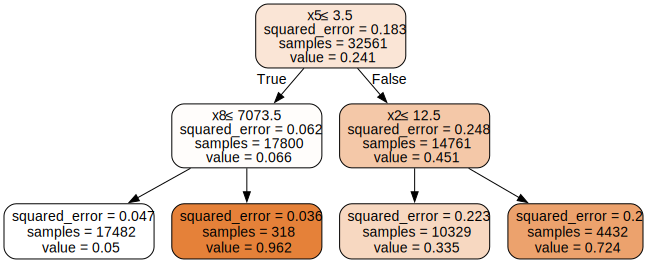

In [4]:
dot_data = sklearn.tree.export_graphviz(orig_model, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [5]:
# Извлекаем массивы, описывающие структуру дерева
children_left = orig_model.tree_.children_left
children_right = orig_model.tree_.children_right
children_default = children_right.copy()  # в scikit-learn отсутствует обработка пропущенных значений, поэтому используем правое поддерево по умолчанию
features = orig_model.tree_.feature
thresholds = orig_model.tree_.threshold
values = orig_model.tree_.value.reshape(orig_model.tree_.value.shape[0], 1)
node_sample_weight = orig_model.tree_.weighted_n_node_samples

print("     children_left", children_left)   # отрицательное значение означает, что узел является листом
print("    children_right", children_right)
print("  children_default", children_default)
print("          features", features)
print("        thresholds", thresholds.round(3))  # значение -2 указывает, что узел является листом
print("            values", values.round(3))
print("node_sample_weight", node_sample_weight)

     children_left [ 1  2 -1 -1  5 -1 -1]
    children_right [ 4  3 -1 -1  6 -1 -1]
  children_default [ 4  3 -1 -1  6 -1 -1]
          features [ 5  8 -2 -2  2 -2 -2]
        thresholds [ 3.5000e+00  7.0735e+03 -2.0000e+00 -2.0000e+00  1.2500e+01 -2.0000e+00
 -2.0000e+00]
            values [[0.241]
 [0.066]
 [0.05 ]
 [0.962]
 [0.451]
 [0.335]
 [0.724]]
node_sample_weight [32561. 17800. 17482.   318. 14761. 10329.  4432.]


In [6]:
# Определение пользовательской модели дерева в виде словаря
tree_dict = {
    "children_left": children_left,              # индексы левых дочерних узлов
    "children_right": children_right,            # индексы правых дочерних узлов
    "children_default": children_default,        # индексы дочерних узлов по умолчанию (в sklearn равны правым, так как отсутствуют пропущенные значения)
    "features": features,                        # индекс признака, по которому происходит разбиение в каждом узле
    "thresholds": thresholds,                    # пороговое значение для разбиения
    "values": values,                            # значения, предсказываемые в узлах (например, средние значения по классам)
    "node_sample_weight": node_sample_weight,    # количество (взвешенных) объектов, попавших в каждый узел
}

# Представление модели в виде словаря, содержащего одно дерево
model = {"trees": [tree_dict]}

In [7]:
explainer = shap.TreeExplainer(model)
# Убедимся, что интерпретатор SHAP (модель TreeEnsemble) выдаёт те же предсказания,
# что и исходная модель
assert np.abs(explainer.model.predict(X) - orig_model.predict(X)).max() < 1e-4

# Убедимся, что сумма SHAP-значений даёт точное значение прогноза модели
# (свойство локальной точности: сумма вкладов признаков плюс базовое значение равна предсказанию)
assert np.abs(explainer.expected_value + explainer.shap_values(X).sum(1) - orig_model.predict(X)).max()